In [12]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
print(tf.__version__)

2.1.0


In [2]:
source_data = pd.read_csv('./气候数据集/DailyDelhiClimateTrain.csv')

生成数据与时间,只对平均气温进行预测

In [3]:
time = source_data['date'].values
data = source_data.drop(['date'],axis=1)['meantemp'].values

### 简单可视化

In [4]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end],series[start:end],'r--',label='meantemp')

    plt.xlabel("Time")
    plt.ylabel("Value")
    
#     plt.grid(True)

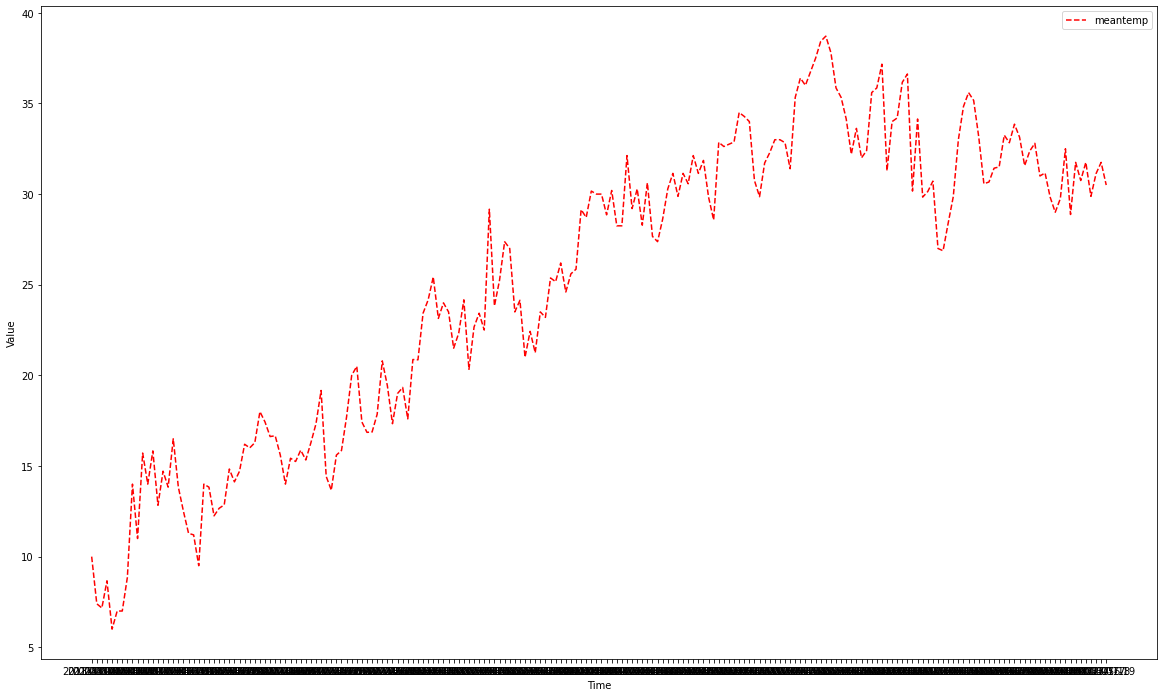

In [5]:
plt.figure(figsize=(20, 12))
plot_series(time, data,start=0,end=200)
plt.legend()
plt.show()

### 划分验证集和训练集

In [6]:
valid_time = time[1000:]
valid_data = data[1000:]
train_time = time[:1000]
train_data = data[:1000]

### 生成适合模型使用的数据

In [7]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """
    返回用于迭代的dataset
    for x,y in dataset:
        print("x = ", x.numpy())
        print("y = ", y.numpy())
    """
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [8]:
dataset = windowed_dataset(train_data, 30, 32, 1000)

In [9]:
for x,y in dataset:
        print("x = ", x.numpy())
        print("y = ", y.numpy())

x =  [[33.625      35.25       33.125      34.625      32.75       32.75
  34.875      35.25       36.875      37.5        38.5        37.625
  37.875      37.25       37.625      32.875      30.25       30.5
  33.875      36.375      36.875      33.875      35.75       38.
  36.875      34.5        32.125      33.         32.25       32.5       ]
 [36.875      34.5        32.125      33.         32.25       32.5
  34.75       34.875      33.         32.         31.375      29.5
  28.875      31.38888889 34.70588235 30.625      34.         35.
  36.         36.125      36.625      35.875      31.625      32.375
  33.125      32.625      30.75       27.25       29.875      30.875     ]
 [30.375      31.125      30.42857143 31.375      31.875      33.
  33.25       32.5        33.         33.125      33.125      33.875
  34.125      33.85714286 29.625      30.375      28.625      27.625
  29.42857143 29.25       28.625      27.875      26.5        28.5
  31.         31.25       31.      

### 模型调教

In [10]:
model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(30,)),
    tf.keras.layers.Dense(32, activation="relu"), 
    tf.keras.layers.Dense(16, activation="relu"), 
    tf.keras.layers.Dense(1)
])

model.compile(loss="mse",  optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
history = model.fit(dataset,epochs=100,verbose=0)

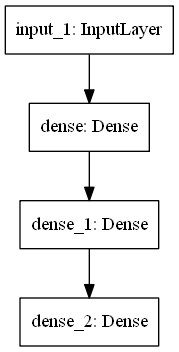

In [13]:
keras.utils.plot_model(model, "my_first_model.png")

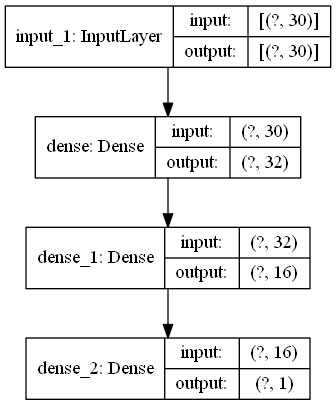

In [14]:
keras.utils.plot_model(model, "my_first_model_with_shape_info.png", show_shapes=True)

In [134]:
model.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_70 (Dense)             (None, 32)                992       
_________________________________________________________________
dense_71 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_72 (Dense)             (None, 1)                 17        
Total params: 1,537
Trainable params: 1,537
Non-trainable params: 0
_________________________________________________________________


In [128]:
forecast = []
for t in range(len(time) - 30):
    forecast.append(model.predict(data[t:t + 30][np.newaxis]))

forecast = forecast[1000-30:]
results = np.array(forecast)[:, 0, 0]

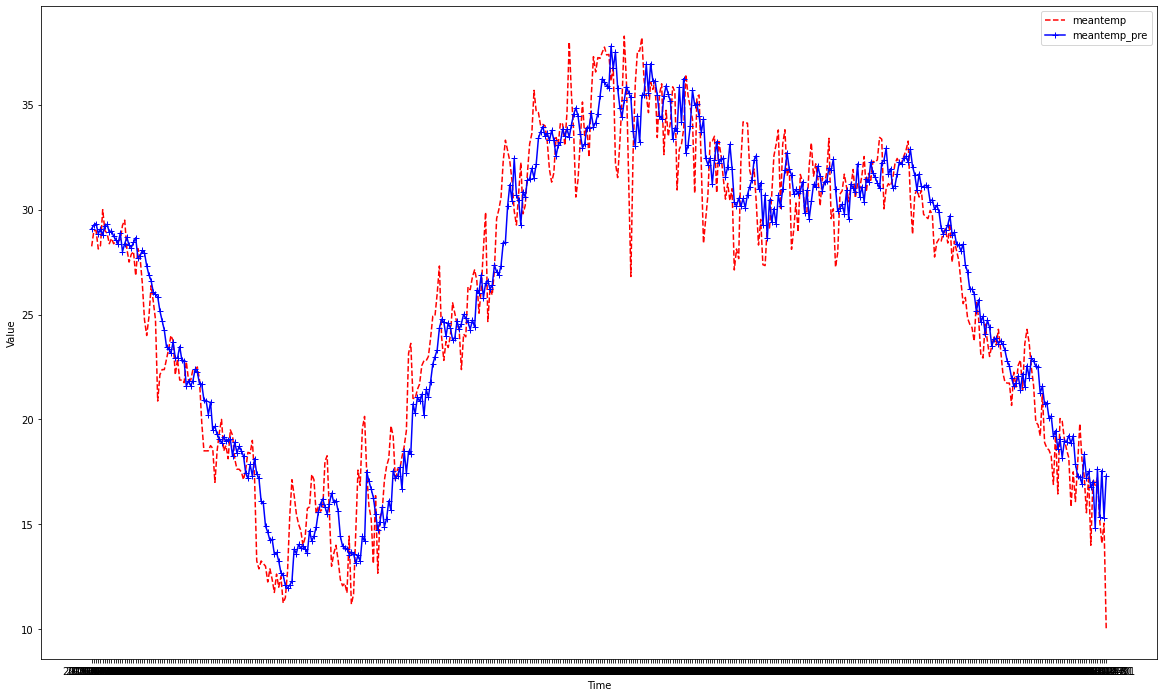

In [129]:
plt.figure(figsize=(20, 12))

plt.plot(time[1000:],valid_data,'r--',label='meantemp')
plt.plot(time[1000:],results,'b+-',label='meantemp_pre')
#     plt.plot(time[start:end],series['wind_speed'][start:end],label='wind_speed')
#     plt.plot(time[start:end],series['meanpressure'][start:end],label='meanpressure')
plt.xlabel("Time")
plt.ylabel("Value")


plt.legend()
plt.show()


# plot_series(time_valid, x_valid)
# plot_series(time_valid, results)

### 查看模型效果

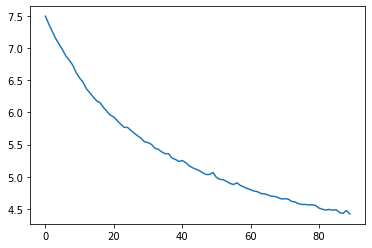

In [120]:
plt.plot(history.history['loss'][10:])

In [117]:
tf.keras.metrics.mean_absolute_error(valid_data, results).numpy()

1.5160627